<a href="https://colab.research.google.com/github/ucfilho/Doubts_Students/blob/master/Cartola_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks for Regression problems

Neural networks are well known for classification problems, for example, they are used in handwritten digits classification, but the question is will it be fruitful if we used them for regression problems?

In this article I will use a deep neural network to predict house pricing using a dataset from Kaggle .

You can download the dataset from [Here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)


![](https://cdn-images-1.medium.com/max/2000/1*vUKwarc7rCouMzSt0Ksakw.jpeg)

## Contents :
    1- Process the dataset
    2- Make the deep neural network
    3- Train the DNN
    4- Test the DNN
    5- Compare the result from the DNN to another ML algorithm

**First of all, we will import the needed dependencies :**

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Using TensorFlow backend.


## First : Processing the dataset 
We will not go deep in processing the dataset, all we want to do is getting the dataset ready to be fed into our models .

We will get rid of any features with missing values, then we will encode the categorical features, that's it.


### Load the dataset :
* Load train and test data into pandas DataFrames
* Combine train and test data to process them together

In [0]:
def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.Pontosx
  train.drop(['Pontosx'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [0]:
combined.describe()

,Rodada x,Preco_x-1,PrecoVariacao_x-1,Ano,Casa x,PontosMedia_x-1,lose_odds,draw_odds,FS_med_x-1,PE_med_x-1,...,PP_l05_x-1,RB_l05_x-1,FC_l05_x-1,GC_l05_x-1,CA_l05_x-1,CV_l05_x-1,SG_l05_x-1,DD_l05_x-1,DP_l05_x-1,GS_l05_x-1
count,7538.000000,7538.000000,7538.000000,7538.0,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,...,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000,7538.000000
mean,24.140621,6966.240382,13.434598,2018.0,0.504378,3085.555850,380.535553,293.316662,1043.376492,1751.366145,...,2.286150,1158.583311,1122.274874,2.498408,173.347705,8.936588,139.719687,100.457681,1.656010,80.078801
std,8.355817,3869.317298,973.547245,0.0,0.500014,1971.544073,181.795183,41.475776,758.404904,1002.508518,...,21.722592,955.686468,791.872804,22.420933,195.311964,46.568756,234.414398,388.260391,21.496108,320.179808
min,10.000000,730.000000,-4730.000000,2018.0,0.000000,-6600.000000,49.000000,138.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,4030.000000,-540.000000,2018.0,0.000000,1800.000000,236.000000,268.000000,500.000000,1000.000000,...,0.000000,400.000000,600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,6200.000000,0.000000,2018.0,1.000000,2920.000000,364.000000,306.000000,1000.000000,1692.000000,...,0.000000,1000.000000,1000.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,31.000000,9220.000000,530.000000,2018.0,1.000000,4230.000000,508.000000,325.000000,1455.000000,2364.000000,...,0.000000,1750.000000,1600.000000,0.000000,200.000000,0.000000,200.000000,0.000000,0.000000,0.000000
max,38.000000,23340.000000,6200.000000,2018.0,1.000000,12830.000000,870.000000,357.000000,8000.000000,8000.000000,...,400.000000,6000.000000,6000.000000,333.000000,1000.000000,1000.000000,1000.000000,3500.000000,1000.000000,3000.000000


let's define a function to get the columns that don't have any missing values 

In [0]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

Get the columns that do not have any missing values .

In [0]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

Let's see how many columns we got

In [0]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 44
Number of nun-numerical columns with no nan values : 4


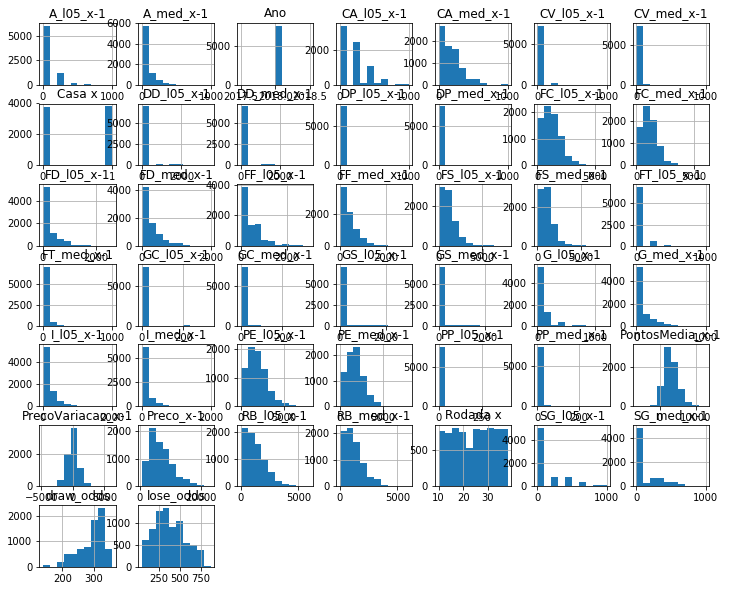

In [0]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

**The correlation between the features**

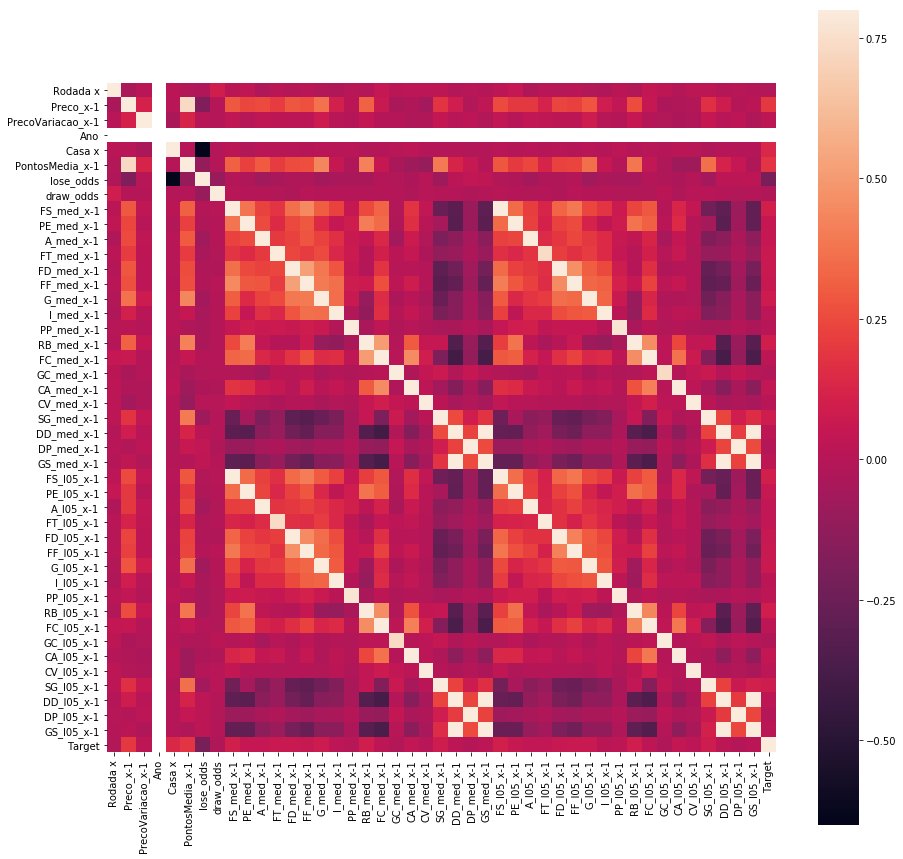

In [0]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

From the correlation heatmap above, we see that about 15 features are highly correlated with the target.

**One Hot Encode The Categorical Features :**

We will encode the categorical features using one hot encoding.

In [0]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [0]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 48 columns before encoding categorical features
There are 667 columns after encoding categorical features


Now, split back combined dataFrame to training data and test data 

In [0]:
def split_combined():
    global combined
    train = combined[:39017]
    test = combined[39017:]

    return train , test 

In [0]:
train, test = split_combined()

## Second : Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer
 


In [0]:
NN_model = Sequential()

**The Input Layer**

In [0]:
NN_model.add(Dense(48, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


**The Hidden Layers**

In [0]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The Output Layer**

In [0]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [0]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 48)                32064     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               12544     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 44,865
Trainable params: 44,865
Non-trainable params: 0
_________________________________________________________________


**Define a checkpoint callback :**

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Third : Train the model :

In [0]:
NN_model.fit(train, target, epochs=50000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 4824 samples, validate on 1206 samples
Epoch 1/50000
4824/4824 [==============================] - 2s 340us/step - loss: 3205.6461 - mean_absolute_error: 3205.6461 - val_loss: 3019.3259 - val_mean_absolute_error: 3019.3259

Epoch 00001: val_loss improved from inf to 3019.32588, saving model to Weights-001--3019.32588.hdf5
Epoch 2/50000
4824/4824 [==============================] - 1s 109us/step - loss: 3147.4496 - mean_absolute_error: 3147.4496 - val_loss: 2992.4452 - val_mean_absolute_error: 2992.4452

Epoch 00002: val_loss improved from 3019.32588 to 2992.44520, saving model to Weights-002--2992.44520.hdf5
Epoch 3/50000
4824/4824 [==============================] - 1s 112us/step - loss: 3146.5416 - mean_absolute_error: 3146.5416 - val_loss: 2995.8618 - val_mean_absolute_error: 2995.8618

Epoch 00003: val_loss did not improve from 2992.44520
Epoch 4/50000
4824/4824 [==============================] - 1s 111us/step - loss: 3129.6166 

In [0]:
# Load wights file of the best model :
wights_file = 'Weights-009--2961.04423.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

We see that the validation loss of the best model is 18738.19 

## Fourth : Test the model
We will submit the predictions on the test data to Kaggle and see how good our model is.

In [0]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'Pontosx':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [0]:
predictions = NN_model.predict(test)

In [0]:
make_submission(predictions[:,0],'submission(NN).csv')

A submission file has been made


![](https://cdn-images-1.medium.com/max/800/1*mXbUrGB9yB9RrBscwugP9g.png)

Not bad at all, with some more preprocessing, and more training, we can do better.


## Fifth: Try another ML algorithms :
Now, let us try another ML algorithm to compare the results.

We will use random forest regressor and XGBRegressor.

**Split training data to training and validation data**

In [0]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)


**We will try Random forest model first.**

In [0]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

**Get the mean absolute error on the validation data **

In [0]:
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  3192.8912466843503


**Make a submission file and submit it to Kaggle to see the result.**

In [0]:
predicted_prices = model.predict(test)
make_submission(predicted_prices,'Submission(RF).csv')

A submission file has been made


![](https://cdn-images-1.medium.com/max/800/1*wcJqKzBsbLARqMjwvv0Xjw.png)

**Now, let us try XGBoost model**

In [0]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

**Get the mean absolute error on the validation data**

In [0]:
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  3053.193298380318


**Make a submission file and submit it to Kaggle to see the result.**

In [0]:
XGBpredictions = XGBModel.predict(test)
make_submission(XGBpredictions,'Submission(XGB).csv')

A submission file has been made


![](https://cdn-images-1.medium.com/max/800/1*PO0jxykz1hv-aSN5kkjItg.png)

Isn't that a surprise, I really did not think that neural networks will beat random forests and XGBoost algorithms, but let us try not to be too optimistic, remember that we did not configure any hyperparameters on random forest and XGBoost models, I believe if we did so, these two models would outscore neural networks.